In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv


# Importing Libraries

In [2]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from imblearn.combine import SMOTEENN
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFE

# Loading Dataset

In [3]:
train_data=pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv")  #Loading train dataset

In [4]:
df=train_data.copy()        # copying dataset into df variable

In [5]:
df.head()                   # checking the Dataset

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target
0,2009-04-17,26,blue-collar,married,secondary,no,647,yes,no,cellular,357,2,331,1,other,no
1,2009-10-11,52,technician,married,secondary,no,553,yes,no,telephone,160,1,-1,0,NaN,no
2,2010-11-20,44,blue-collar,married,secondary,no,1397,no,no,cellular,326,1,-1,0,NaN,no
3,2009-09-01,33,admin.,married,secondary,no,394,yes,no,telephone,104,3,-1,0,NaN,no
4,2008-01-29,31,entrepreneur,single,tertiary,no,137,no,no,cellular,445,2,-1,0,NaN,no


# EDA 

In [6]:
df.isnull().sum()

last contact date        0
age                      0
job                    229
marital                  0
education             1467
default                  0
balance                  0
housing                  0
loan                     0
contact              10336
duration                 0
campaign                 0
pdays                    0
previous                 0
poutcome             29451
target                   0
dtype: int64

In [7]:
df.isnull().sum()/df.isnull().sum().sum()*100

last contact date     0.000000
age                   0.000000
job                   0.552033
marital               0.000000
education             3.536388
default               0.000000
balance               0.000000
housing               0.000000
loan                  0.000000
contact              24.916231
duration              0.000000
campaign              0.000000
pdays                 0.000000
previous              0.000000
poutcome             70.995347
target                0.000000
dtype: float64

1. **we can set there are missing values in categorical columns. since all the missing columns are categorical we can try imputing with most frequent value.**
2. poutcome has almost 75 percent missing entries.

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,39211.0,42.120247,12.709352,18.0,33.0,40.0,50.0,95.0
balance,39211.0,5441.781719,16365.292065,-8019.0,98.0,549.0,2030.0,102127.0
duration,39211.0,439.062789,769.096291,0.0,109.0,197.0,380.0,4918.0
campaign,39211.0,5.108770,9.890153,1.0,1.0,2.0,4.0,63.0
pdays,39211.0,72.256051,160.942593,-1.0,-1.0,-1.0,-1.0,871.0
previous,39211.0,11.826171,44.140259,0.0,0.0,0.0,0.0,275.0


Age:

1. we can see that minimum age is age maximum upto 95.and  interesting fact is that almost 75 percent of the candidates is below age of 50.
2. median of the age is 40 which means most of the candidates ages around 40.

Balance:

1. there are candidates whose balance are negative. which may indicate they are in debt.
2. balance has a higher variance may help with generalization
3. on average candidates has 5441 in their account.

Duration:

1. higher in variance
2. on average 440 seconds duration of the call during contact.

campgaign:

1. most people attempted campaign around 5

pdays:

1. most people have never contacted before.
2. maximum p days is 871


previous:

1. 75 percent of the candidated is previously contacted 0 times. maximum of 275.




In [9]:
df.age.median()

40.0

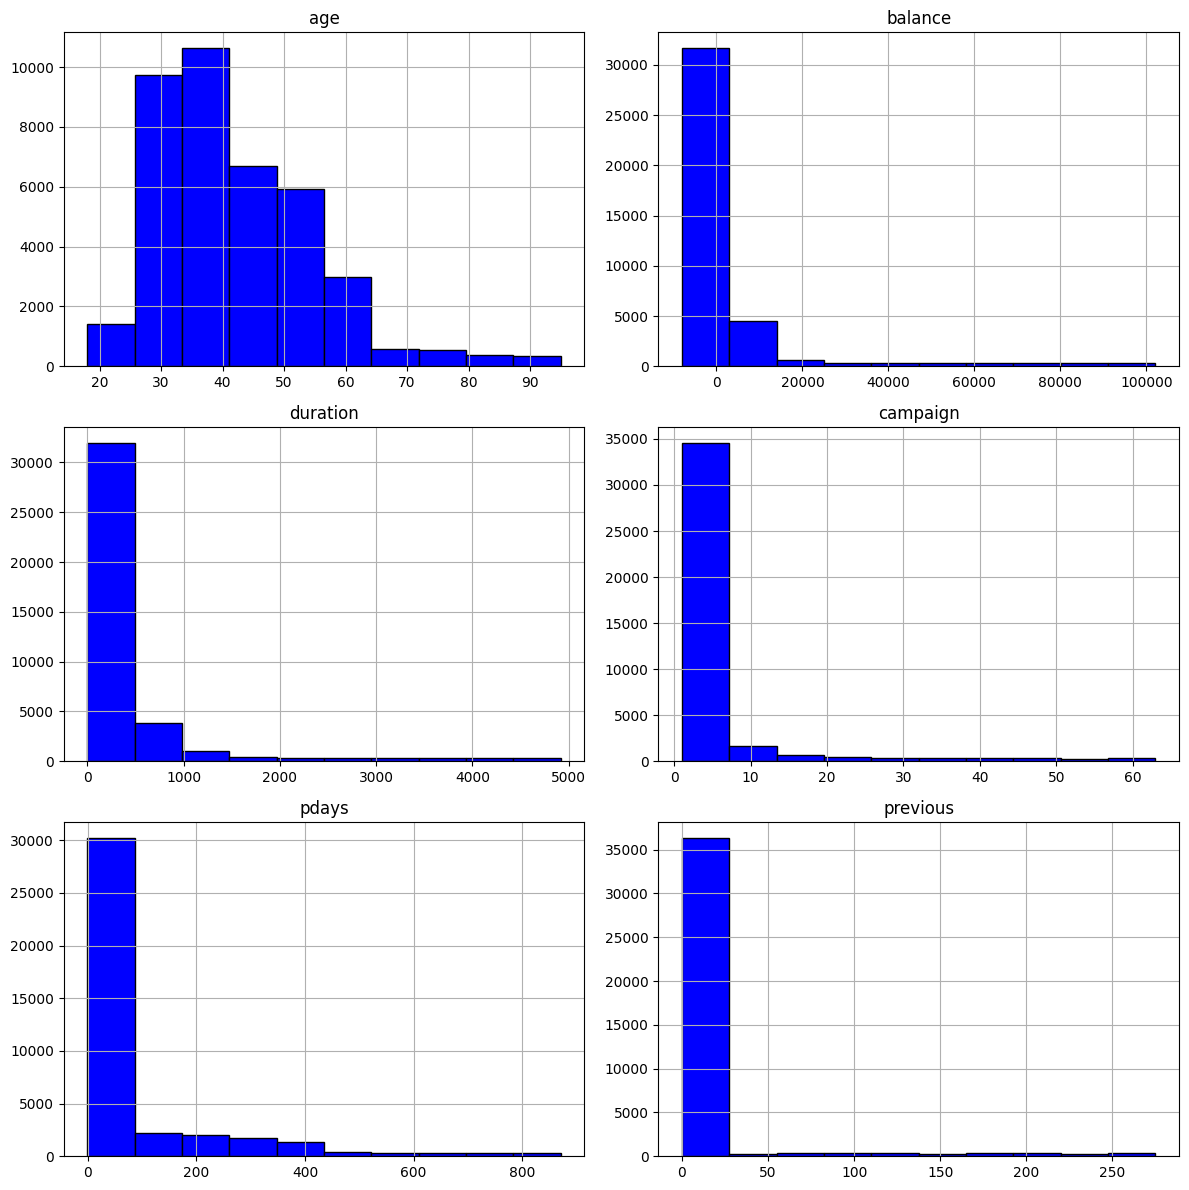

In [10]:
# draw an histogram
df.hist(figsize=(12, 12), color='blue', edgecolor='black')
plt.tight_layout()
plt.show()

Distributions:

**From the histograms we can see that age is normally distributed and all other numerical columns are exponentially distributted.**

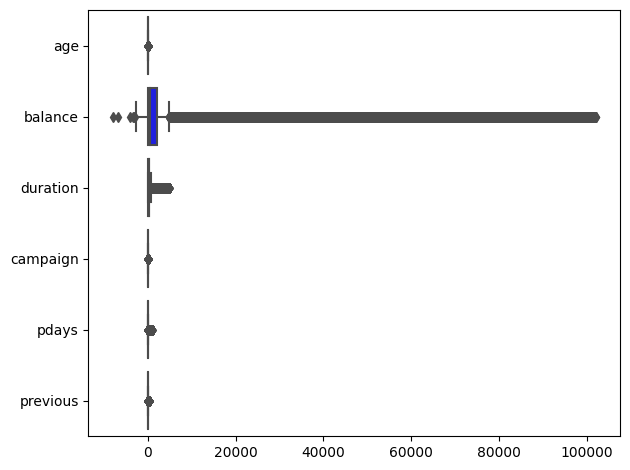

In [11]:
#Draw boxplot for numerical columns
sns.boxplot(data=df, orient='h', color='blue')
plt.tight_layout()
plt.show()

Outliers:

From that boxplot we can conclude that there is higher outlier in balance column. so it is recommended to remove the outlier.

Note: We need to understand the dependancy between input features . It can be done by creating correlation matrix between Feature Variablres.

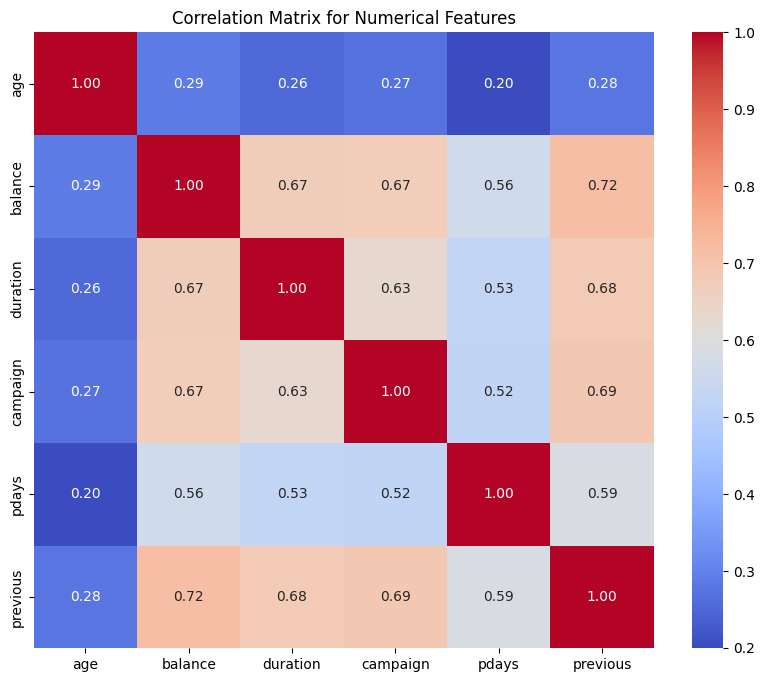

In [12]:
numerical_columns = ['age','balance', 'duration', 'campaign', 'pdays', 'previous']  # create a list of numerical feature names
plt.figure(figsize=(10, 8))                                                         # define size of the heatmap
corr_matrix = df[numerical_columns].corr()                                          # create correlation matrix
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')                    # create heatmap
plt.title('Correlation Matrix for Numerical Features')                              # define title of the heatmap
plt.show() 

correlations:
1. age is not correlated with other features
2. balance is strogly correlated with duration, coampaign, pdays ,and previous
   
note: other than age all other featues are strogly correlated with each other columns.

# Preprocessing

## 1. Removing Outliers

In [13]:
        Q1 = df['balance'].quantile(0.10) # 10 percentile for q1 
        Q3 = df['balance'].quantile(0.90) # 90 percentile for q2


        factor=1.5
        IQR = Q3 - Q1


        lower_bound = Q1 - factor * IQR    # defining lower bound
        upper_bound = Q3 + factor * IQR    # defining upper bound

                                                                                    
        df = df[( df['balance'] >= lower_bound) & ( df['balance'] <= upper_bound)]     # Filter rows within bounds

## 2. Handling Missing Values

In [14]:
si=SimpleImputer(strategy="most_frequent")                                                     # imputing missing values with most frequent category

In [15]:
df[['job','education', 'contact']]=si.fit_transform(df[['job','education', 'contact']])        # imputing missing values with most frequent category 

In [16]:
df["poutcome"] = df["poutcome"].fillna("No contact")                                           # filling missing values with "No contact" by using p days features

## 3. Encoding the Dataset

In [17]:
encoder=OrdinalEncoder()                                                                                        # Initialising Encoder

In [18]:
df[['loan','housing', 'default', 'target']]=encoder.fit_transform(df[['loan','housing', 'default', 'target']])  # Encoding selcted Columns

In [19]:
df.head()                                                                                                        #Checking the dataset

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target
0,2009-04-17,26,blue-collar,married,secondary,0.0,647,1.0,0.0,cellular,357,2,331,1,other,0.0
1,2009-10-11,52,technician,married,secondary,0.0,553,1.0,0.0,telephone,160,1,-1,0,No contact,0.0
2,2010-11-20,44,blue-collar,married,secondary,0.0,1397,0.0,0.0,cellular,326,1,-1,0,No contact,0.0
3,2009-09-01,33,admin.,married,secondary,0.0,394,1.0,0.0,telephone,104,3,-1,0,No contact,0.0
4,2008-01-29,31,entrepreneur,single,tertiary,0.0,137,0.0,0.0,cellular,445,2,-1,0,No contact,0.0


In [20]:
x=df.loc[:,:'poutcome']                                   # seperating features from dataset and stored as a x variable
y=df.target                                               # seperating target from dataset and stored as a y variable                  

# Feature Engineering

I am going to create a new features called days since last contact. i am fixing  "2020-12-31" the date as  a a refernce and subtract from last contact date. 

In [21]:
x['last contact date'] = pd.to_datetime(x['last contact date'])                            # convert data to Datetime
reference_date = pd.to_datetime("2010-12-31")                                              # Assigning reference date
x['days_since_last_contact'] = (reference_date - x['last contact date']).dt.days           # create new feature for last contact

Create seperate columns for date month and weekday. And remove last contact date feature.

In [22]:
x['day'] = x['last contact date'].dt.day                     # convert data to Day
x['month'] = x['last contact date'].dt.month                 # convert data to month
x['year'] =x['last contact date'].dt.year                    # convert data to year
x['weekday'] =x['last contact date'].dt.day_name()           # convert data to week day
x = x.drop(columns=['last contact date'])                    # last contact date is dropped.
x.head()

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,days_since_last_contact,day,month,year,weekday
0,26,blue-collar,married,secondary,0.0,647,1.0,0.0,cellular,357,2,331,1,other,623,17,4,2009,Friday
1,52,technician,married,secondary,0.0,553,1.0,0.0,telephone,160,1,-1,0,No contact,446,11,10,2009,Sunday
2,44,blue-collar,married,secondary,0.0,1397,0.0,0.0,cellular,326,1,-1,0,No contact,41,20,11,2010,Saturday
3,33,admin.,married,secondary,0.0,394,1.0,0.0,telephone,104,3,-1,0,No contact,486,1,9,2009,Tuesday
4,31,entrepreneur,single,tertiary,0.0,137,0.0,0.0,cellular,445,2,-1,0,No contact,1067,29,1,2008,Tuesday


By looking at histograms , tthe data is grouped for few featues. so i will create bins for age , days_since_last_contact, balance features it may helpful for generalisation.

BINS FOR "days_since_last_contact"

In [23]:
age_bin = [18, 30, 45, 60, x['age'].max()]                                                                #create bins for age  
labels_age = ['Young', 'Adult', 'Middle-aged', 'old']                                                     #create labels for age 
x['age_bin'] = pd.cut(x['age'], bins=age_bin, labels=labels_age, right=True)                              #create new column and apply bins for age 

In [24]:
bins_recency = [0, 30, 90, 180, x['days_since_last_contact'].max()]                                                      #create bins for last contact date
labels_recency = ['Very Recent', 'Recent', 'Moderate', 'Old']                                                            #create labels for last contact date
x['recency_bin'] = pd.cut(x['days_since_last_contact'], bins=bins_recency, labels=labels_recency, right=True)            #create new column and apply bins for last contact date  

In [25]:
bins_duration = [0, 120, 300, x.duration.max()]                                                           #create bins for duration
labels_duration = ['Short', 'Medium', 'Long']                                                             #create labels for duration
x['duration_bin'] = pd.cut(x['duration'], bins=bins_duration, labels=labels_duration, right=True)         #create new column for bin

In [26]:
# create bins for balance
balance_quantiles = x['balance'].quantile([0.25, 0.75]).values
bins_balance = [-float('inf'), balance_quantiles[0], balance_quantiles[1], float('inf')]
labels_balance = ['Low', 'Medium', 'High']
x['balance_bin'] = pd.cut(x['balance'], bins=bins_balance, labels=labels_balance)

In [27]:
#create new column if the candidate has a single contact or multiple times

x['contact_type'] = x['campaign'].apply(lambda x: 'Single Contact' if x == 1 else 'Multiple Contacts')   

In [28]:
x.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,duration,...,days_since_last_contact,day,month,year,weekday,age_bin,recency_bin,duration_bin,balance_bin,contact_type
0,26,blue-collar,married,secondary,0.0,647,1.0,0.0,cellular,357,...,623,17,4,2009,Friday,Young,Old,Long,Medium,Multiple Contacts
1,52,technician,married,secondary,0.0,553,1.0,0.0,telephone,160,...,446,11,10,2009,Sunday,Middle-aged,Old,Medium,Medium,Single Contact
2,44,blue-collar,married,secondary,0.0,1397,0.0,0.0,cellular,326,...,41,20,11,2010,Saturday,Adult,Recent,Long,Medium,Single Contact
3,33,admin.,married,secondary,0.0,394,1.0,0.0,telephone,104,...,486,1,9,2009,Tuesday,Adult,Old,Short,Medium,Multiple Contacts
4,31,entrepreneur,single,tertiary,0.0,137,0.0,0.0,cellular,445,...,1067,29,1,2008,Tuesday,Adult,Old,Long,Medium,Multiple Contacts


In [29]:
# Function to combbine housing and loan
def housing_loan_combination(row):
    if row['housing'] == 'yes' and row['loan'] == 'yes':
        return 'Both Loans'
    elif row['housing'] == 'yes' and row['loan'] == 'no':
        return 'Housing Loan Only'
    elif row['housing'] == 'no' and row['loan'] == 'yes':
        return 'Personal Loan Only'
    else:
        return 'No Loans'
# applying function on the dataset
x['loan_combination'] = x.apply(housing_loan_combination, axis=1)


# combining job and age  
x['customer_profile'] = x['age_bin'].astype(str) + "_" + x['job']


# combining campaign and previous
x['interaction_campaign_previous'] = x['campaign'] * x['previous']


#combining balance and contact
x['balance_contact_combo'] = x['balance_bin'].astype(str) + "_" +x['contact_type']


x[['loan_combination', 'customer_profile', 'interaction_campaign_previous', 'balance_contact_combo']].head()

,loan_combination,customer_profile,interaction_campaign_previous,balance_contact_combo
0,No Loans,Young_blue-collar,2,Medium_Multiple Contacts
1,No Loans,Middle-aged_technician,0,Medium_Single Contact
2,No Loans,Adult_blue-collar,0,Medium_Single Contact
3,No Loans,Adult_admin.,0,Medium_Multiple Contacts
4,No Loans,Adult_entrepreneur,0,Medium_Multiple Contacts


In [30]:
def pbool(x):          # function to conmvert pdays to binary
    if x<=0:
        return 0
    if x>0:
        return 1
def rmneg(x):         # function to conmvert balance to binary
    if x<=0:
        return 0
    else:
        return x

In [31]:
#Applying the above function to pdays and balance columns.
x['pdays_bool']=x["pdays"].apply(pbool)
x['balance_bool']=x["balance"].apply(pbool)

In [32]:
#Applying the above function to pdays and balance columns.
x['pos_balance']=x['balance'].apply(rmneg)
x['pos_pdays']=x['pdays'].apply(rmneg)

In [33]:
x.shape

(36510, 32)

## 1. Encoding Engineered Feature 

In [34]:
cat_=list(x.select_dtypes(exclude="int").columns)
num_=list(x.select_dtypes(include="int").columns)

In [35]:
#pipeline for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'), cat_),   # applying one got encoder for categorical columns
        ('scaler', MinMaxScaler(), num_)                                       # scaling numerical columns
    ],
    remainder='passthrough' 
)

In [36]:
pre_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
   
])

In [37]:
pre_pipeline.fit(x)                                                               # fitting the pipeline

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'poutcome', 'weekday',
                                                   'age_bin', 'recency_bin',
                                                   'duration_bin',
                                                   'balance_bin',
                                                   'contact_type',
                                                   'loan_combination',
                                                   'customer_profile',
                                                   'balance_contact_combo']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['age', 'balance', 'duration',
                                                   'campaign', 'pdays',
                                                   'previous',
                                                   'days_since_last_contact',
                                                   'day', 'month', 'year',
                                                   'interaction_campaign_previous',
                                                   'pdays_bool', 'balance_bool',
                                                   'pos_balance',
                                                   'pos_pdays'])]))])

In [38]:
#transform the feature columns according to column transformer
X_transformed = pre_pipeline.transform(x)

X_transformed_df = pd.DataFrame(X_transformed, columns=pre_pipeline.get_feature_names_out())

X_transformed_df.head()

,ohe__job_admin.,ohe__job_blue-collar,ohe__job_entrepreneur,ohe__job_housemaid,ohe__job_management,ohe__job_retired,ohe__job_self-employed,ohe__job_services,ohe__job_student,ohe__job_technician,...,scaler__previous,scaler__days_since_last_contact,scaler__day,scaler__month,scaler__year,scaler__interaction_campaign_previous,scaler__pdays_bool,scaler__balance_bool,scaler__pos_balance,scaler__pos_pdays
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.003636,0.569597,0.533333,0.272727,0.5,0.000118,1.0,1.0,0.031897,0.380023
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.000000,0.407509,0.333333,0.818182,0.5,0.000000,0.0,1.0,0.027263,0.000000
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.036630,0.633333,0.909091,1.0,0.000000,0.0,1.0,0.068872,0.000000
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.444139,0.000000,0.727273,0.5,0.000000,0.0,1.0,0.019424,0.000000
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.976190,0.933333,0.000000,0.0,0.000000,0.0,1.0,0.006754,0.000000


# Splitting  Dataset for validation 

In [39]:
#Dataset splitted for training and testing( 80 percent for training 20 percent testing)
X_train,X_test,Y_train,Y_test=train_test_split(X_transformed_df,y, test_size=0.20,random_state=42)

# Handling Unbalanced Data

In [40]:
# using smote to resample the dataset
smote = SMOTEENN(sampling_strategy='minority',random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, Y_train)

# Model Buliding

## 1. **XGB MODEL**

In [41]:
#Model Fitting
XGB = xgb.XGBClassifier(random_state=42)               
XGB.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [42]:
#predicting on test data
y_pred = XGB.predict(X_test)
report = classification_report(Y_test, y_pred)       # to find f1 score for test dataset for XGB model
print(report)

              precision    recall  f1-score   support

         0.0       0.96      0.88      0.92      6365
         1.0       0.49      0.78      0.60       937

    accuracy                           0.87      7302
   macro avg       0.73      0.83      0.76      7302
weighted avg       0.90      0.87      0.88      7302



In [43]:
print(confusion_matrix(Y_test, y_pred))

[[5603  762]
 [ 209  728]]


## 2. **RANDOM  FOREST MODEL**

In [44]:
#Model Fitting
RFC=RandomForestClassifier(random_state=42)
RFC.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [45]:
#predicting on test data
y_pred = RFC.predict(X_test)
report = classification_report(Y_test, y_pred)      # to find f1 score for test dataset for Random Forest model   
print(report)

              precision    recall  f1-score   support

         0.0       0.96      0.84      0.90      6365
         1.0       0.42      0.79      0.55       937

    accuracy                           0.83      7302
   macro avg       0.69      0.81      0.72      7302
weighted avg       0.89      0.83      0.85      7302



In [46]:
print(confusion_matrix(Y_test, y_pred))

[[5329 1036]
 [ 196  741]]


## 3. **LOGISTIC REGRESSION MODEL**

In [47]:
#Model Fitting
log=LogisticRegression(random_state=42, max_iter=1000)       
log.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=1000, random_state=42)

In [48]:
#predicting on test data
y_pred = log.predict(X_test)
report = classification_report(Y_test, y_pred)       # to find f1 score for test dataset for Random Forest model
print(report)

              precision    recall  f1-score   support

         0.0       0.98      0.74      0.84      6365
         1.0       0.33      0.88      0.48       937

    accuracy                           0.75      7302
   macro avg       0.65      0.81      0.66      7302
weighted avg       0.89      0.75      0.79      7302



In [49]:
print(confusion_matrix(Y_test, y_pred))

[[4688 1677]
 [ 116  821]]


# Comparing Base Models

In [50]:
results = {"Model": [], "Accuracy": [], "Precision": [], "Recall": [], "F1": [], "ROC-AUC": []}   # creating Dictionary to save scores.

In [51]:
for name, model in [("Random Forest", RFC), 
                    ("Logistic Regression", log), 
                    ("XGBoost", XGB)]:
    # Predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Metrics
    results["Model"].append(name)
    results["Accuracy"].append(accuracy_score(Y_test, y_pred))
    results["Precision"].append(precision_score(Y_test, y_pred))
    results["Recall"].append(recall_score(Y_test, y_pred))
    results["F1"].append(f1_score(Y_test, y_pred))
    results["ROC-AUC"].append(roc_auc_score(Y_test, y_prob))


df_results = pd.DataFrame(results)


print(df_results)


                 Model  Accuracy  Precision    Recall        F1   ROC-AUC
0        Random Forest  0.831279   0.416995  0.790822  0.546057  0.891971
1  Logistic Regression  0.754451   0.328663  0.876201  0.478020  0.883736
2              XGBoost  0.867023   0.488591  0.776948  0.599918  0.913960


# Parameter Tuning and Feature Elimination

In [52]:
# defining parameters for XGB
param_dist = {
    'classification__n_estimators': [50, 100, 200],       # number of trees in xgb model 
    'classification__max_depth': [3, 5, 7],               # maximum depth of tree in the Xgb model
    'classification__learning_rate': [0.01, 0.1, 0.2],    # step_size
    'classification__subsample': [0.6, 0.8, 1.0],         # percentage of samples used for training
    'classification__colsample_bytree': [0.6, 0.8, 1.0],  # feature selection
    'classification__gamma': [0, 1, 5],                   # reduce overfitting
    'classification__reg_lambda': [1, 10, 50],            # applying l2 regularization.
}

In [53]:
#initiating Recursive Feature Elimimination
rfe = RFE(estimator=XGB, n_features_to_select=40)

In [54]:
#pipeline for feature elimination and model 
pipeline = Pipeline([
    ('feature_selection', rfe),
    ('classification', XGB)
])

In [55]:
#initiating RandomSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    scoring='f1',           # setting scoring as f1
    n_iter=50,              # Number of combinations to try
    cv=5,                   # 5-fold cross-validation
    random_state=42,
    verbose=2,              #to print process
    n_jobs=-1
)

In [56]:
random_search.fit(X_train_resampled, y_train_resampled)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END classification__colsample_bytree=1.0, classification__gamma=1, classification__learning_rate=0.1, classification__max_depth=7, classification__n_estimators=100, classification__reg_lambda=1, classification__subsample=0.8; total time= 6.9min
[CV] END classification__colsample_bytree=1.0, classification__gamma=1, classification__learning_rate=0.1, classification__max_depth=7, classification__n_estimators=100, classification__reg_lambda=1, classification__subsample=0.8; total time= 7.6min
[CV] END classification__colsample_bytree=0.8, classification__gamma=5, classification__learning_rate=0.1, classification__max_depth=3, classification__n_estimators=200, classification__reg_lambda=1, classification__subsample=1.0; total time= 7.5min
[CV] END classification__colsample_bytree=0.8, classification__gamma=0, classification__learning_rate=0.01, classification__max_depth=5, classification__n_estimators=50, classification__re

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('feature_selection',
                                              RFE(estimator=XGBClassifier(base_score=None,
                                                                          booster=None,
                                                                          callbacks=None,
                                                                          colsample_bylevel=None,
                                                                          colsample_bynode=None,
                                                                          colsample_bytree=None,
                                                                          device=None,
                                                                          early_stopping_rounds=None,
                                                                          enable_categorical=False,
                                                                          eval_metric=None,
                                                                          feature_types=None,
                                                                          gamma=None,
                                                                          grow_policy=None,
                                                                          importance_t...
                   param_distributions={'classification__colsample_bytree': [0.6,
                                                                             0.8,
                                                                             1.0],
                                        'classification__gamma': [0, 1, 5],
                                        'classification__learning_rate': [0.01,
                                                                          0.1,
                                                                          0.2],
                                        'classification__max_depth': [3, 5, 7],
                                        'classification__n_estimators': [50,
                                                                         100,
                                                                         200],
                                        'classification__reg_lambda': [1, 10,
                                                                       50],
                                        'classification__subsample': [0.6, 0.8,
                                                                      1.0]},
                   random_state=42, scoring='f1', verbose=2)

In [57]:
Tuned_XGB_Model=random_search.best_estimator_
Tuned_XGB_Model

Pipeline(steps=[('feature_selection',
                 RFE(estimator=XGBClassifier(base_score=None, booster=None,
                                             callbacks=None,
                                             colsample_bylevel=None,
                                             colsample_bynode=None,
                                             colsample_bytree=None, device=None,
                                             early_stopping_rounds=None,
                                             enable_categorical=False,
                                             eval_metric=None,
                                             feature_types=None, gamma=None,
                                             grow_policy=None,
                                             importance_type=None,
                                             interaction_constraints=N...
                               feature_types=None, gamma=1, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=50, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [58]:
# to check claasification report
y_pred = Tuned_XGB_Model.predict(X_test)
report = classification_report(Y_test, y_pred)
print(report)
print(accuracy_score(Y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.83      0.89      6365
         1.0       0.41      0.83      0.55       937

    accuracy                           0.83      7302
   macro avg       0.69      0.83      0.72      7302
weighted avg       0.90      0.83      0.85      7302

0.8278553820870994


# Preparing test dataset

In [59]:
test_data=pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv")

In [60]:
df=test_data.copy()

In [61]:
df.shape

(10000, 15)

In [62]:
df.head()

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome
0,2009-11-21,36,management,single,tertiary,no,7,no,no,NaN,20,1,-1,0,NaN
1,2010-02-04,30,unemployed,married,tertiary,no,1067,no,no,cellular,78,2,-1,0,NaN
2,2010-07-28,32,blue-collar,single,secondary,no,82,yes,no,cellular,86,4,-1,0,NaN
3,2010-06-09,38,admin.,married,primary,no,1487,no,no,NaN,332,2,-1,0,NaN
4,2008-03-02,59,management,married,tertiary,no,315,no,no,cellular,591,1,176,2,failure


In [63]:
si=SimpleImputer(strategy="most_frequent")

In [64]:
si=SimpleImputer(strategy="most_frequent")                                                     # imputing missing values with most frequent category
df[['job','education', 'contact']]=si.fit_transform(df[['job','education', 'contact']])        # imputing missing values with most frequent category 
df["poutcome"] = df["poutcome"].fillna("No contact")                                           # filling missing values with "No contact" by using p days features
df[['loan','housing', 'default']]=encoder.fit_transform(df[['loan','housing', 'default']])
x=df.loc[:,:'poutcome']                                  
# seperating target from dataset and stored as a y variable     
x['last contact date'] = pd.to_datetime(x['last contact date'])                            # convert data to Datetime
reference_date = pd.to_datetime("2010-12-31")                                              # Assigning reference date
x['days_since_last_contact'] = (reference_date - x['last contact date']).dt.days           # create new feature for last contact       
x['day'] = x['last contact date'].dt.day                     # convert data to Day
x['month'] = x['last contact date'].dt.month                 # convert data to month
x['year'] =x['last contact date'].dt.year                    # convert data to year
x['weekday'] =x['last contact date'].dt.day_name()           # convert data to week day
x = x.drop(columns=['last contact date'])                    # last contact date is dropped.
x.head()      
age_bin = [18, 30, 45, 60, x['age'].max()]                                                                #create bins for age  
labels_age = ['Young', 'Adult', 'Middle-aged', 'old']                                                     #create labels for age 
x['age_bin'] = pd.cut(x['age'], bins=age_bin, labels=labels_age, right=True)                              #create new column and apply bins for age
bins_recency = [0, 30, 90, 180, x['days_since_last_contact'].max()]                                                      #create bins for last contact date
labels_recency = ['Very Recent', 'Recent', 'Moderate', 'Old']                                                            #create labels for last contact date
x['recency_bin'] = pd.cut(x['days_since_last_contact'], bins=bins_recency, labels=labels_recency, right=True)            #create new column and apply bins for last contact date  
bins_duration = [0, 120, 300, x.duration.max()]                                                           #create bins for duration
labels_duration = ['Short', 'Medium', 'Long']                                                             #create labels for duration
x['duration_bin'] = pd.cut(x['duration'], bins=bins_duration, labels=labels_duration, right=True)         #create new column for bin
# create bins for balance
balance_quantiles = x['balance'].quantile([0.25, 0.75]).values
bins_balance = [-float('inf'), balance_quantiles[0], balance_quantiles[1], float('inf')]
labels_balance = ['Low', 'Medium', 'High']
x['balance_bin'] = pd.cut(x['balance'], bins=bins_balance, labels=labels_balance)


def housing_loan_combination(row):
    if row['housing'] == 'yes' and row['loan'] == 'yes':
        return 'Both Loans'
    elif row['housing'] == 'yes' and row['loan'] == 'no':
        return 'Housing Loan Only'
    elif row['housing'] == 'no' and row['loan'] == 'yes':
        return 'Personal Loan Only'
    else:
        return 'No Loans'

#create new column if the candidate has a single contact or multiple times

x['contact_type'] = x['campaign'].apply(lambda x: 'Single Contact' if x == 1 else 'Multiple Contacts') 


# applying function on the dataset
x['loan_combination'] = x.apply(housing_loan_combination, axis=1)


# combining job and age  
x['customer_profile'] = x['age_bin'].astype(str) + "_" + x['job']


# combining campaign and previous
x['interaction_campaign_previous'] = x['campaign'] * x['previous']


#combining balance and contact
x['balance_contact_combo'] = x['balance_bin'].astype(str) + "_" +x['contact_type']


x[['loan_combination', 'customer_profile', 'interaction_campaign_previous', 'balance_contact_combo']].head()
#Applying the above function to pdays and balance columns.
x['pdays_bool']=x["pdays"].apply(pbool)
x['balance_bool']=x["balance"].apply(pbool)
#Applying the above function to pdays and balance columns.
x['pos_balance']=x['balance'].apply(rmneg)
x['pos_pdays']=x['pdays'].apply(rmneg)

In [65]:
X_transformed = pre_pipeline.transform(x)

X_transformed_df = pd.DataFrame(X_transformed, columns=pre_pipeline.get_feature_names_out())

X_transformed_df.head()

,ohe__job_admin.,ohe__job_blue-collar,ohe__job_entrepreneur,ohe__job_housemaid,ohe__job_management,ohe__job_retired,ohe__job_self-employed,ohe__job_services,ohe__job_student,ohe__job_technician,...,scaler__previous,scaler__days_since_last_contact,scaler__day,scaler__month,scaler__year,scaler__interaction_campaign_previous,scaler__pdays_bool,scaler__balance_bool,scaler__pos_balance,scaler__pos_pdays
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.369963,0.666667,0.909091,0.5,0.000000,0.0,1.0,0.000345,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.301282,0.100000,0.090909,1.0,0.000000,0.0,1.0,0.052603,0.000000
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.141941,0.900000,0.545455,1.0,0.000000,0.0,1.0,0.004043,0.000000
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.186813,0.266667,0.454545,1.0,0.000000,0.0,1.0,0.073309,0.000000
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.007273,0.945971,0.033333,0.181818,0.0,0.000118,1.0,1.0,0.015529,0.202067


# Predicting the test Dataset

In [66]:
out=XGB.predict(X_transformed_df)

In [67]:
test_data['out']=out
test_data['out']=test_data['out'].map({1:'yes',0:'no'})
test_data['out'].describe()

count     10000
unique        2
top          no
freq       7496
Name: out, dtype: object

In [68]:
submission = pd.DataFrame({
    'id': range(0, len(out)),
    'target': test_data['out']
})

## Submission  

In [69]:
submission.to_csv('submission.csv',index=False)